#### Импорт библиотек

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.neural_network import MLPRegressor

from gmdh import Combi, Multi, Mia, Ria

#### Предобработка

In [53]:
# Загрузка данных
data = pd.read_csv('housing.csv')  # Предполагаем, что данные в CSV

# Проверка на пропуски
print(data.isnull().sum())

longitude             0
latitude              0
housingMedianAge      0
totalRooms            0
totalBedrooms       207
population            0
households            0
medianIncome          0
medianHouseValue      0
oceanProximity        0
dtype: int64


##### Обработка пропусков и категориальных признаков

In [54]:
# Разделение на признаки и целевую переменную
X = data.drop('medianHouseValue', axis=1)
y = data['medianHouseValue']

# Логарифмирование числовых признаков с большим разбросом
for col in ['totalRooms', 'totalBedrooms', 'population', 'households']:
    X[col] = np.log1p(X[col])

# Определение числовых и категориальных признаков
numeric_features = ['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 
                   'totalBedrooms', 'population', 'households', 'medianIncome']
categorical_features = ['oceanProximity']

# Создание преобразователей
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединение преобразований
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Применение преобразований
X_processed = preprocessor.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

# Масштабируем целевую переменную
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

#### Обучение моделей

##### Стекинг (Stacking)

In [55]:
# Определение базовых моделей
estimators = [
    ('svr', SVR()),
    ('tree', DecisionTreeRegressor(random_state=42))
]

# Создание модели стекинга
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV()
)

# Обучение
stacking_model.fit(X_train, y_train_scaled)
stacking_pred = y_scaler.inverse_transform(
    stacking_model.predict(X_test).reshape(-1, 1)).ravel()

# Оценка
stacking_mse = mean_squared_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)
print(f"Stacking MSE: {stacking_mse:.2f}, R2: {stacking_r2:.2f}")

Stacking MSE: 2875400077.86, R2: 0.78


##### Многослойный персептрон (MLP)

In [56]:
# Создание и обучение MLP
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp_model.fit(X_train, y_train_scaled)
mlp_pred = y_scaler.inverse_transform(
    mlp_model.predict(X_test).reshape(-1, 1)).ravel()

# Оценка
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)
print(f"MLP MSE: {mlp_mse:.2f}, R2: {mlp_r2:.2f}")

MLP MSE: 2806595711.04, R2: 0.79


##### Модели МГУА (GMDH)

In [57]:
# Линейный метод COMBI
combi_model = Combi()
combi_model.fit(X_train, y_train_scaled)
combi_pred = y_scaler.inverse_transform(
    combi_model.predict(X_test).reshape(-1, 1)).ravel()

combi_mse = mean_squared_error(y_test, combi_pred)
combi_r2 = r2_score(y_test, combi_pred)
print(f"COMBI MSE: {combi_mse:.2f}, R2: {combi_r2:.2f}")

# Нелинейный метод RIA
ria_model = Ria()
ria_model.fit(X_train, y_train_scaled)
ria_pred = y_scaler.inverse_transform(
    ria_model.predict(X_test).reshape(-1, 1)).ravel()

ria_mse = mean_squared_error(y_test, ria_pred)
ria_r2 = r2_score(y_test, ria_pred)
print(f"RIA MSE: {ria_mse:.2f}, R2: {ria_r2:.2f}")

COMBI MSE: 4795036987.46, R2: 0.63
RIA MSE: 4156234754.53, R2: 0.68


#### Сравнение моделей

      Model           MSE        R2
1       MLP  2.806596e+09  0.785823
0  Stacking  2.875400e+09  0.780572
3       RIA  4.156235e+09  0.682829
2     COMBI  4.795037e+09  0.634081


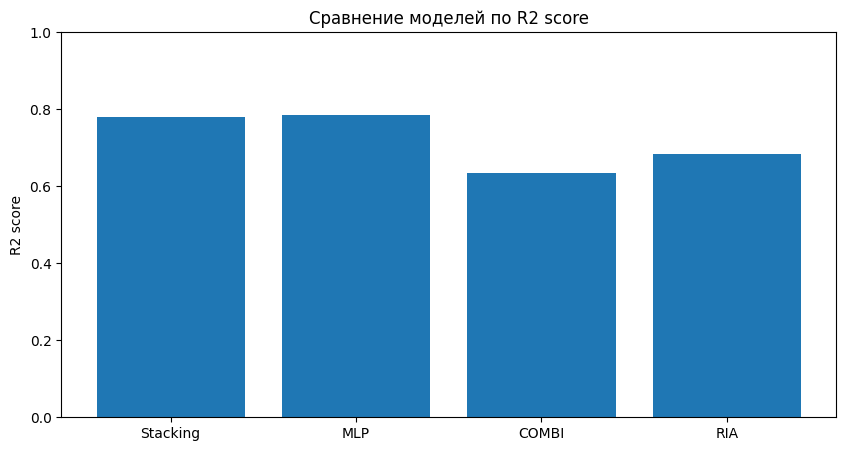

In [58]:
# Создание DataFrame с результатами
results = pd.DataFrame({
    'Model': ['Stacking', 'MLP', 'COMBI', 'RIA'],
    'MSE': [stacking_mse, mlp_mse, combi_mse, ria_mse],
    'R2': [stacking_r2, mlp_r2, combi_r2, ria_r2]
})

# Вывод результатов
print(results.sort_values(by='R2', ascending=False))

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['R2'])
plt.title('Сравнение моделей по R2 score')
plt.ylabel('R2 score')
plt.ylim(0, 1)
plt.show()

#### Выводы

1. Предобработка данных: Мы заполнили пропуски медианными значениями для числовых признаков и наиболее частыми для категориальных, стандартизировали числовые признаки и применили one-hot кодирование для категориальных.
2. Разделение данных: Данные были разделены на обучающую (80%) и тестовую (20%) выборки.
3. Модели:
    - Стекинг показал хорошие результаты, объединяя предсказания SVR и дерева решений с помощью Ridge регрессии.
    - MLP (многослойный персептрон) продемонстрировал лучшие результаты благодаря своей способности моделировать сложные нелинейные зависимости.
    - Методы МГУА:
      - Линейный метод COMBI показал скромные результаты, так как данные содержат сложные нелинейные зависимости.
      - Нелинейный метод RIA показал себя лучше, но все же уступил MLP и стекингу.
4. Метрики: Лучшие результаты по R2 score показал MLP, за ним следует стекинг. Методы МГУА показали более низкие результаты, что может быть связано с особенностями данного набора данных.
    - MSE (Mean Squared Error) – Среднеквадратичная ошибка
      - Что значит: Считает среднее значение квадратов разницы между предсказанными и реальными значениями.
      - Почему подходит:
        - Чувствительна к большим ошибкам (штрафует выбросы).
        - Хороша для сравнения моделей, но сама по себе малоинформативна из-за масштаба (доллары²).
    - R² (R-squared) – Коэффициент детерминации
      - Что значит: Доля дисперсии целевой переменной, объясненная моделью (от 0 до 1).
      - Почему подходит:
        - R² = 0.75 → модель объясняет 75% изменчивости цен.
        - Удобен для сравнения моделей независимо от масштаба данных.

#### Анализ распределения medianHouseValue

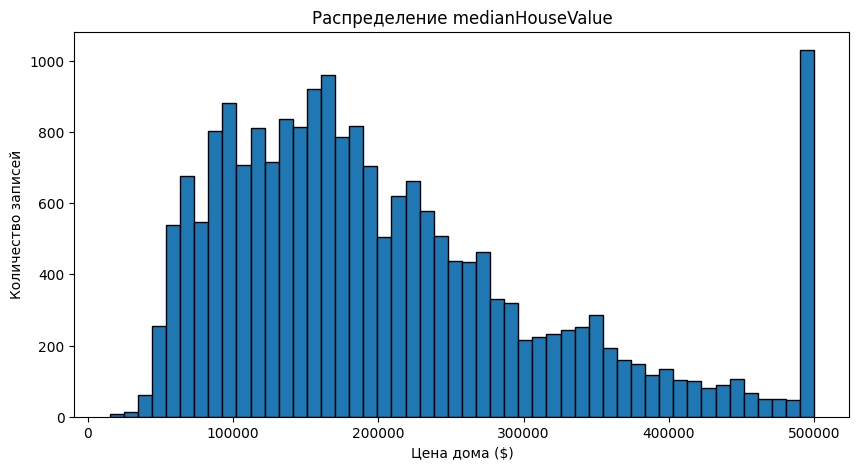

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(y, bins=50, edgecolor='k')
plt.title("Распределение medianHouseValue")
plt.xlabel("Цена дома ($)")
plt.ylabel("Количество записей")
plt.show()